In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

%matplotlib inline

# read in arealstatistik land cover data and drop unnecessary columns
path = ''
file_name = 'AREA_Interpretationsresultate.csv'
df = pd.read_csv(f'{path}{file_name}', nrows=5000000)
df = df[['X_COORD','Y_COORD','FJ4','LC4_27','LC4_6']]
df = df.rename(columns={'X_COORD':'X', 'Y_COORD':'Y'})
df = df.dropna(axis=0,how='any')

print(df.shape)
# 2709450
df.head()

(2709450, 5)


,X,Y,FJ4,LC4_27,LC4_6
0,488900,112700,2012.0,11.0,10.0
1,489000,111400,2012.0,47.0,40.0
2,490700,116700,2012.0,11.0,10.0
3,491100,114500,2012.0,21.0,20.0
4,491200,117800,2012.0,46.0,40.0


In [2]:
# remap land cover according to remap dictionaries

# remap function
def remap(row):
    
    remap_dict1 = {10: 0, 20: 1, 30: 2, 40: 3, 50: 4}
    remap_dict2 = {61: 5, 62: 6, 63: 5, 64: 5}
    
    # everything but 'watery areas' (60) is simply remapped
    if row['LC4_6'] == 60: # watery areas
        return remap_dict2.get(int(row['LC4_27']))  
    else: # non watery areas
        return remap_dict1.get(int(row['LC4_6']))
    # end of remap function


# apply function to data frame
df['land_cover'] = df.apply(remap, axis=1)
df.head()

,X,Y,FJ4,LC4_27,LC4_6,land_cover
0,488900,112700,2012.0,11.0,10.0,0
1,489000,111400,2012.0,47.0,40.0,3
2,490700,116700,2012.0,11.0,10.0,0
3,491100,114500,2012.0,21.0,20.0,1
4,491200,117800,2012.0,46.0,40.0,3


In [3]:
# convert data frame to a numpy array

# get indices based on coordinates
x_min = df['X'].min(); y_min = df['Y'].min()
df['ix'] = (df['X'] - x_min)//100; df['iy'] = (df['Y'] - y_min)//100

# create numpy array

# indices start with 0 => +1 to get number of elemements
n_columns = df['ix'].max()+1; n_rows = df['iy'].max()+1

# [n rows, n columns]
land_cover = np.full((n_rows,n_columns),-1,dtype=int)
year = np.full((n_rows,n_columns),-1,dtype=int)
print('shape:',land_cover.shape)

# transfer data frame data to array
for index, row in df.iterrows():
    
    land_cover[int(row['iy']),int(row['ix'])] = int(row['land_cover'])
    year[int(row['iy']),int(row['ix'])] = int(row['FJ4'])
    
    if index%1000000 == 0: print(index)
    # end of loop
    


shape: (1863, 2833)
0
2000000
3000000


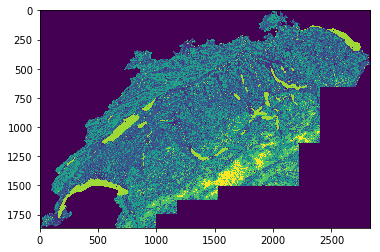

In [4]:
# flip numpy array upside-down
land_cover = np.flip(land_cover,axis=0)
year = np.flip(year,axis=0)

# display results
plt.imshow(land_cover)

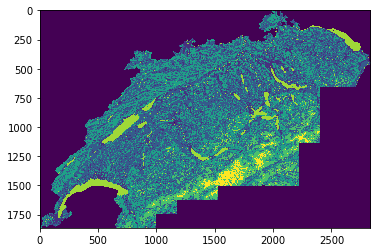

In [5]:
# interpolating missing values
# using the most frequent land cover in the 3x3 neighborhood

def adjacent_class_counts(kernel):
    
    assert(kernel.shape==(3,3))
    
    class_counts = {}
    for index, _ in np.ndenumerate(kernel):
        irow, icol = index
        if irow != 1 or icol!= 1:
            class_ = int(kernel[index[0],index[1]])
            count = class_counts.get(class_,0)
            class_counts[class_] = count + 1
    
    return class_counts

def interpolate(image):
     
    offset = 1
    new_image = np.copy(image)
    
    # loop over all pixels ignoring edges
    for i in range(offset,image.shape[0]-offset):
        for j in range(offset,image.shape[1]-offset):
            class_ = int(image[i,j])
            
            if class_ == -1:
                kernel = image[i-offset:i+offset+1,j-offset:j+offset+1]
                class_counts = adjacent_class_counts(kernel)
                n_nodata = class_counts.get(-1,0)
                if n_nodata == 0:
                    class_interp = max(class_counts, key=class_counts.get)
                    new_image[i,j] = class_interp
               
    return new_image


land_cover_interp = interpolate(land_cover)
plt.imshow(land_cover_interp)

In [6]:
datacube = np.full((n_rows,n_columns,3),-1,dtype=int)
datacube[:,:,0] = land_cover
datacube[:,:,1] = land_cover_interp
datacube[:,:,2] = year

band_names = ['land cover','land cover interp','flight year']

In [7]:
# get coordinates
x_min, x_max, y_min, y_max = (df['X'].min(), df['X'].max(), df['Y'].min(), df['Y'].max())
n_rows, n_cols = np.shape(land_cover)
x_res, y_res = (100, 100)
geotransform = (x_min-50, x_res, 0, y_max+50, 0, -y_res)

print(x_min, x_max)
print(y_min, y_max)

485500 768700
109700 295900


In [8]:
# export array as geo tiff file
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

# function to export a numpy array (arr) as geo tiff
def export_geotiff(fname, arr, x_min, y_max, x_res, y_res, crs, band_names):
    
    n_rows, n_cols, n_bands = np.shape(arr)
    
    geotransform = (x_min-50, x_res, 0, y_max+50, 0, -y_res)
    
    # open geo tiff file
    geotiff = gdal.GetDriverByName('GTiff').Create(fname+'.tif',n_cols, n_rows, n_bands, gdal.GDT_Int16)
    geotiff.SetGeoTransform(geotransform)
    
    # set crs
    srs = osr. SpatialReference()
    srs.ImportFromEPSG(crs)
    geotiff.SetProjection(srs.ExportToWkt())
    
    # write array to geo tiff
    for iband in range(n_bands):
        raster_band = geotiff.GetRasterBand(iband+1)
        raster_band.WriteArray(arr[:,:,iband])
        raster_band.SetDescription(band_names[iband])
        raster_band.FlushCache()
    
    # end of export geo tiff function


export_geotiff('arealstatistik_landcover_2013',datacube,x_min,y_max,100,100,21781,band_names)